In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


In [2]:
os.chdir(r'c:\Users\karina mehta\UVA class\UnderstandingUncertainity\git_practice\group_git\snp_data')

In [25]:
sp_comp = pd.read_csv('sp500_companies.csv')
sp_index = pd.read_csv('sp500_index.csv')
sp_stocks = pd.read_csv('sp500_stocks.csv')

### Markov Chain

How likely will it be a bearish/bullish day

#### Individual Stock level

In [26]:
sp_stocks.head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,2010-01-04,MMM,44.016731,69.414719,69.774246,69.122070,69.473244,3640265.0
1,2010-01-05,MMM,43.741032,68.979935,69.590302,68.311035,69.230766,3405012.0
2,2010-01-06,MMM,44.361343,69.958191,70.735786,69.824417,70.133781,6301126.0
3,2010-01-07,MMM,44.393166,70.008362,70.033447,68.662209,69.665550,5346240.0
4,2010-01-08,MMM,44.705967,70.501671,70.501671,69.648827,69.974915,4073337.0


In [33]:
sp_stocks = sp_stocks.sort_values(['Date','Symbol'])
#Percent Change of Adj Close from previous day to the next day for each stock
sp_stocks['pct_change'] = sp_stocks['Adj Close'].pct_change()
#First row will return NaN since there is no previous day to compare 
sp_stocks = sp_stocks.dropna(subset=['pct_change'])


C:\Users\karina mehta\AppData\Local\Temp\ipykernel_21404\2226441882.py:3: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  sp_stocks['pct_change'] = sp_stocks['Adj Close'].pct_change()


In [34]:
# Creating state of 'bear' and 'bull'
# Bear: Market is down i.e. negative change
# Bull: Market is up i.e. positive change
sp_stocks['State'] = sp_stocks['pct_change'].apply(lambda x: 'Bull' if x > 0 else 'Bear')

In [35]:
sp_stocks['State'].value_counts()

State
Bear    986956
Bull    904575
Name: count, dtype: int64

In [9]:
#Individual Markov chain according to each symbol/ticker

ticker = sp_stocks['Symbol'].unique()
transition_matrices = {}

for t in ticker:
    ticker_state = sp_stocks[sp_stocks['Symbol'] == t].sort_values('Date')['State'].values
    transition_matrices[t] = pd.crosstab(ticker_state[:-1], ticker_state[1:], normalize='index')


In [12]:
transition_matrices['AAPL']

col_0,Bear,Bull
row_0,,
Bear,0.468025,0.531975
Bull,0.469500,0.530500


### Sector-Level Analysis

In [10]:
#Creating a dataframe for each sector names and marketcap and weight according to symbols and their states
sp_sector = sp_stocks.merge(sp_comp[['Symbol','Sector','Marketcap','Weight']], how='left', on='Symbol')

In [11]:
sp_sector.head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,pct_change,State,Sector,Marketcap,Weight
0,2010-01-05,MMM,43.741032,68.979935,69.590302,68.311035,69.230766,3405012.0,-0.006264,Bear,Industrials,70400581632,0.001267
1,2010-01-06,MMM,44.361343,69.958191,70.735786,69.824417,70.133781,6301126.0,0.014181,Bull,Industrials,70400581632,0.001267
2,2010-01-07,MMM,44.393166,70.008362,70.033447,68.662209,69.665550,5346240.0,0.000717,Bull,Industrials,70400581632,0.001267
3,2010-01-08,MMM,44.705967,70.501671,70.501671,69.648827,69.974915,4073337.0,0.007046,Bull,Industrials,70400581632,0.001267
4,2010-01-11,MMM,44.525723,70.217392,70.735786,69.740807,70.551842,3500812.0,-0.004032,Bear,Industrials,70400581632,0.001267


In [13]:
sector_groups = sp_sector[['Symbol','Sector']].drop_duplicates()

In [16]:
# Unique sectors
sectors = sector_groups['Sector'].unique()
sector_transitions = {}

for sector in sectors:

    # Going through the tickers in each sector
    symbol_sector = sector_groups[sector_groups['Sector'] == sector]['Symbol']
    # Creating a list for matrics and weights for each sector
    matrics, weights = [], []

    # Going through the tickers in each sector
    for t in symbol_sector:

        # Going through the transition matrices for each of the tickers
        if t in transition_matrices:
            # Adding the transition matrix of the ticker to the sector list
            matrics.append(transition_matrices[t])
            # Adding the weight of the ticker to the sector list
            weight = sp_comp.loc[sp_comp['Symbol'] == t, 'Marketcap'].values[0]
            weights.append(weight)

    if matrics:

        matrics = [m.values if isinstance(m, pd.DataFrame) else m for m in matrics]

        #Weighted_sum of the matrics and weights
        weighted_sum = sum(m*w for m,w in zip(matrics, weights))
        #Averaging out the weighted sum
        avg_matrix = weighted_sum / sum(weights)
        #Adding the transition matrix of each sector to a dictionary
        sector_transitions[sector] = avg_matrix

In [17]:
sector_transitions['Financial Services']

array([[0.46607978, 0.53392022],
       [0.48869449, 0.51130551]])

In [19]:
import seaborn as sns

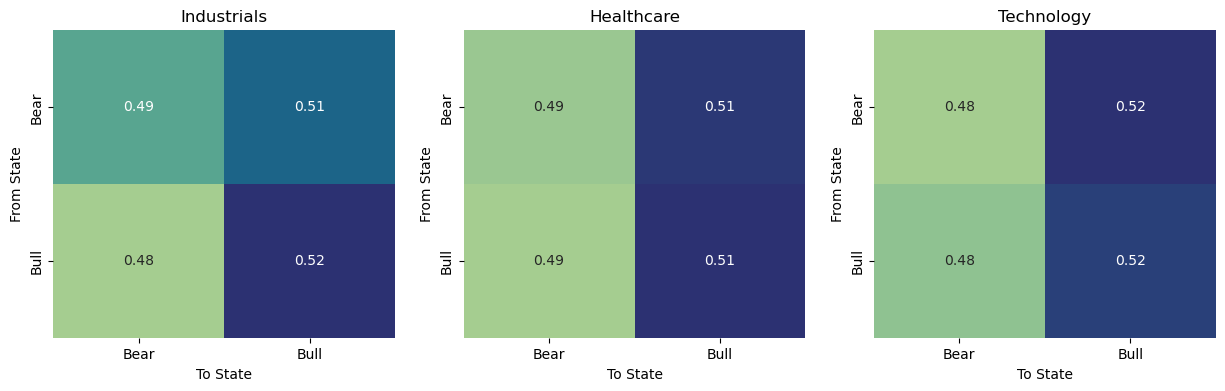

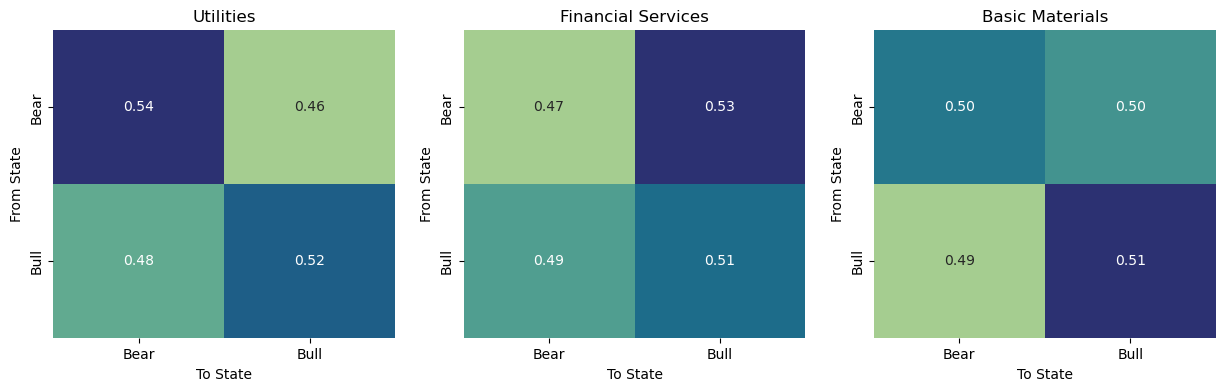

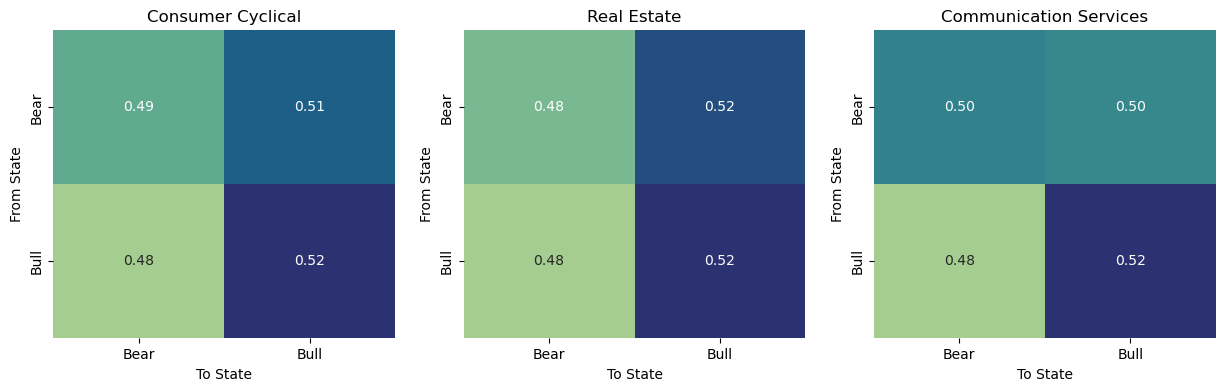

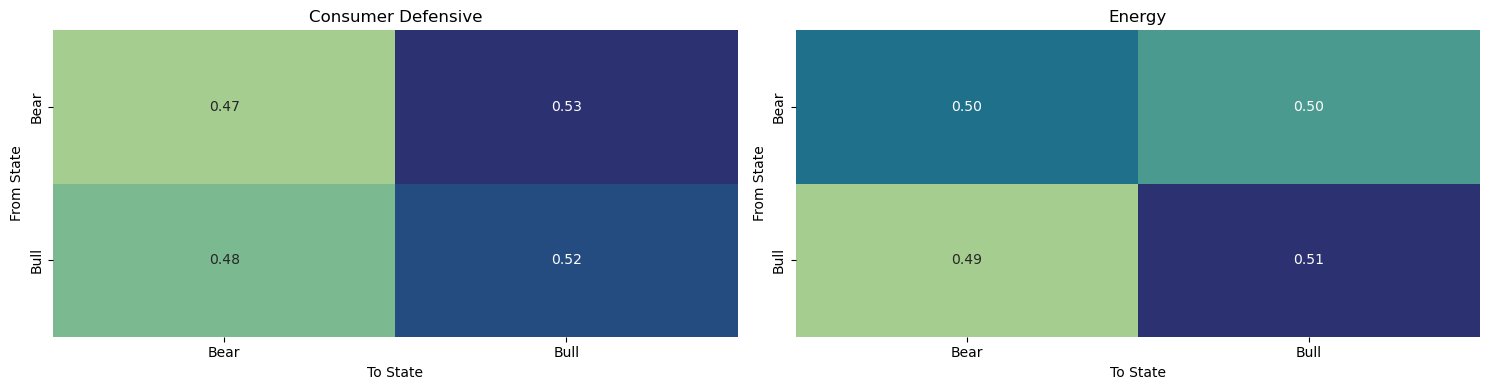

In [22]:
sectors_per_plot = 3

for i in range(0,len(sectors),sectors_per_plot):
    selected = sectors[i:i+sectors_per_plot]

    fig, axes = plt.subplots(1, len(selected), figsize=(15, 4))

    for ax, sector in zip(axes, selected):
        matrix = sector_transitions[sector]
        sns.heatmap(matrix, annot=True, cmap='crest', cbar=False, fmt='.2f', ax=ax,
                    xticklabels=['Bear','Bull'], yticklabels=['Bear','Bull'])
        ax.set_title(sector)
        ax.set_xlabel('To State')
        ax.set_ylabel('From State')

plt.tight_layout()
plt.show()

In [23]:
summary = pd.DataFrame({
    sector: sector_transitions[sector].flatten()
    for sector in sectors
}, index=['Bear→Bear', 'Bear→Bull', 'Bull→Bear', 'Bull→Bull']).T

summary.head()

,Bear→Bear,Bear→Bull,Bull→Bear,Bull→Bull
Industrials,0.492163,0.507837,0.481250,0.518750
Healthcare,0.486826,0.513174,0.485680,0.514320
Technology,0.479583,0.520417,0.482836,0.517164
Utilities,0.540983,0.459017,0.479783,0.520217
Financial Services,0.466080,0.533920,0.488694,0.511306


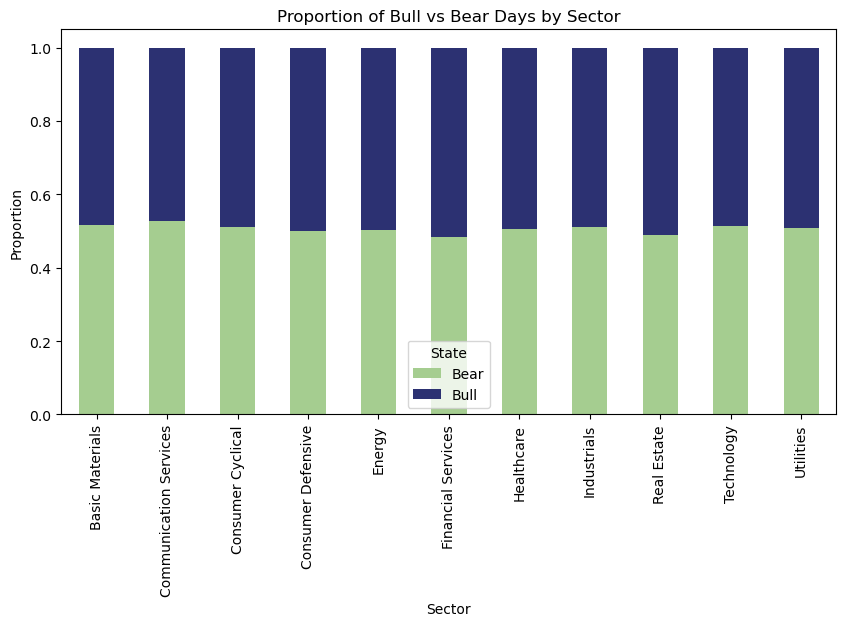

In [24]:
state_counts = (
    sp_sector.groupby(['Sector', 'State'])
    .size()
    .unstack(fill_value=0)
    .apply(lambda x: x / x.sum(), axis=1)
)

state_counts.plot(kind='bar', stacked=True, figsize=(10,5), colormap='crest')
plt.title('Proportion of Bull vs Bear Days by Sector')
plt.xlabel('Sector')
plt.ylabel('Proportion')
plt.show()
